In [1]:
#basics
import numpy as np
import pandas as pd

#viz
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(palette='colorblind')

#modules
import wrangle

/opt/homebrew/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


##### Do additional wrangling
- convert date columns to datetimes
- get datediff column
- drop image urls and entry point urls (/, search, index)


##### Question 6 - What topics are grads continuing to reference after graduation and into their jobs (for each program)?

- Full stack java and php cohorts accessed these classes most after graduation:
  - Javascript i
  - Html - css
  - spring
- Data Science cohorts accessed these classes most after graduation:
  - Intro to Data Science
    - Note: this was aggregated across multiple naming conventions - likely due to a change in website structure
  - MySQL Overview
  - Classification Overview

*With a greater understanding of the site layout and how the site structure changed in the past, further insights could be provided*


In [2]:
def q6_wrangle(old_df):
    df = old_df.copy()
    #Convert these columns to datetimes
    df['date'] = pd.to_datetime(df['date'],format='%Y-%m-%d')
    df['start_date'] = pd.to_datetime(df['start_date'],format='%Y-%m-%d')
    df['end_date'] = pd.to_datetime(df['end_date'],format='%Y-%m-%d')
    #filter dataset down to just post-graduation visits
    df = df[df.date > df.end_date]
    #get a days after graduation column
    df['days_post_grad'] = (df['date'] - df['end_date']).astype('timedelta64[D]')
    #drop entry points ('/','index.html' and 'search/search_index.json')
    df = df[(df.path != '/') & (df.path != 'search/search_index.json') & (df.path != 'index.html')]
    #also drop images
    df = df[~(df.path.str.endswith('.jpg')) & ~(df.path.str.endswith('.jpeg')) & ~(df.path.str.endswith('.svg'))]
    return df

In [3]:
#acquire data
df = wrangle.get_curriculum_data()
df = q6_wrangle(df)

Returning saved csv files.


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 172216 entries, 1 to 900222
Data columns (total 17 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   date            172216 non-null  datetime64[ns]
 1   time            172216 non-null  object        
 2   path            172216 non-null  object        
 3   user_id         172216 non-null  int64         
 4   cohort_id       172216 non-null  float64       
 5   ip              172216 non-null  object        
 6   id              172216 non-null  float64       
 7   name            172216 non-null  object        
 8   slack           172216 non-null  object        
 9   start_date      172216 non-null  datetime64[ns]
 10  end_date        172216 non-null  datetime64[ns]
 11  created_at      172216 non-null  object        
 12  updated_at      172216 non-null  object        
 13  deleted_at      0 non-null       float64       
 14  program_id      172216 non-null  flo

##### Question 6:  What topics are grads continuing to reference after graduation and into their jobs (for each program)?

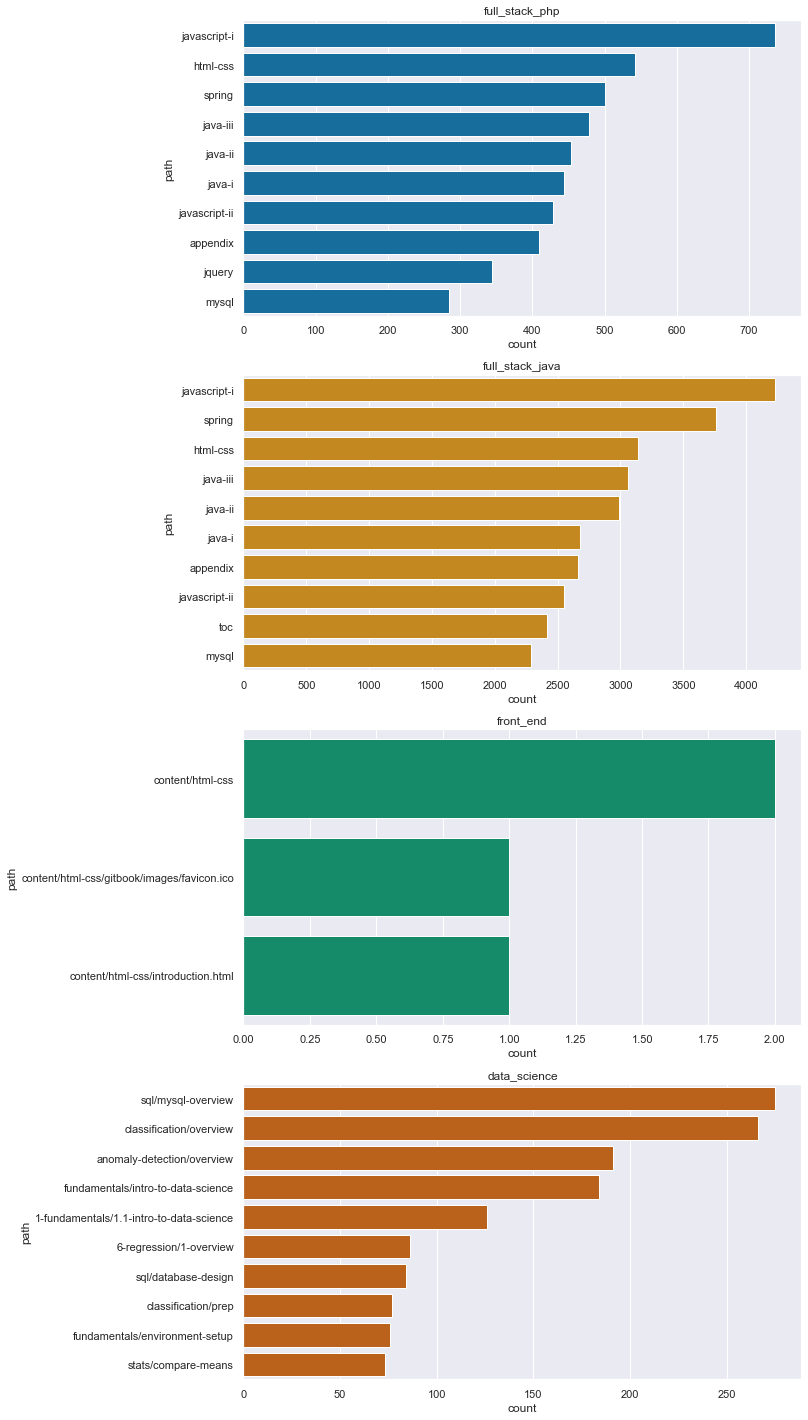

In [5]:
plt.figure(figsize=(10,25))
colors = sns.color_palette('colorblind').as_hex()
# length = len(df.program_name.nunique())
#loop over each program
for cnt,p in enumerate(df.program_name.unique()):
    #get subset of site visits for this program
    df_prog = df[df.program_name == p]
    #get top visits
    df_prog_top = pd.DataFrame(df_prog.path.value_counts()).rename(columns={'path':'count'})
    df_prog_top['path'] = df_prog_top.index
    #plot top 10 visits per program
    plt.subplot(4,1,cnt+1)
    plt.title(p);
    plt.xlabel('Number of post-graduation visits')
    sns.barplot(y = 'path', x = 'count',data= df_prog_top.head(10), orient = 'h',color=colors[cnt])
    

In [6]:
#Put all into one function:
def question6(df):
    #do some more wrangling
    df6 = q6_wrangle(df)
    #Plot most popular websites:
    plt.figure(figsize=(10,25))
    colors = sns.color_palette('colorblind').as_hex()
    # length = len(df.program_name.nunique())
    #loop over each program
    cnt=1
    for p in df6.program_name.unique():
        if p == 'front_end': continue
        #get subset of site visits for this program
        df_prog = df6[df6.program_name == p]
        #get top visits
        df_prog_top = pd.DataFrame(df_prog.path.value_counts()).rename(columns={'path':'count'})
        df_prog_top['path'] = df_prog_top.index
        #plot top 10 visits per program
        plt.subplot(3,1,cnt)
        plt.title(f'Top 10 site visits for {p}',size=14);
        sns.barplot(y = 'path', x = 'count',data= df_prog_top.head(10), orient = 'h',color=colors[cnt]);
        plt.xlabel('Number of post-graduation site visits');
        cnt+=1
    return None

Returning saved csv files.


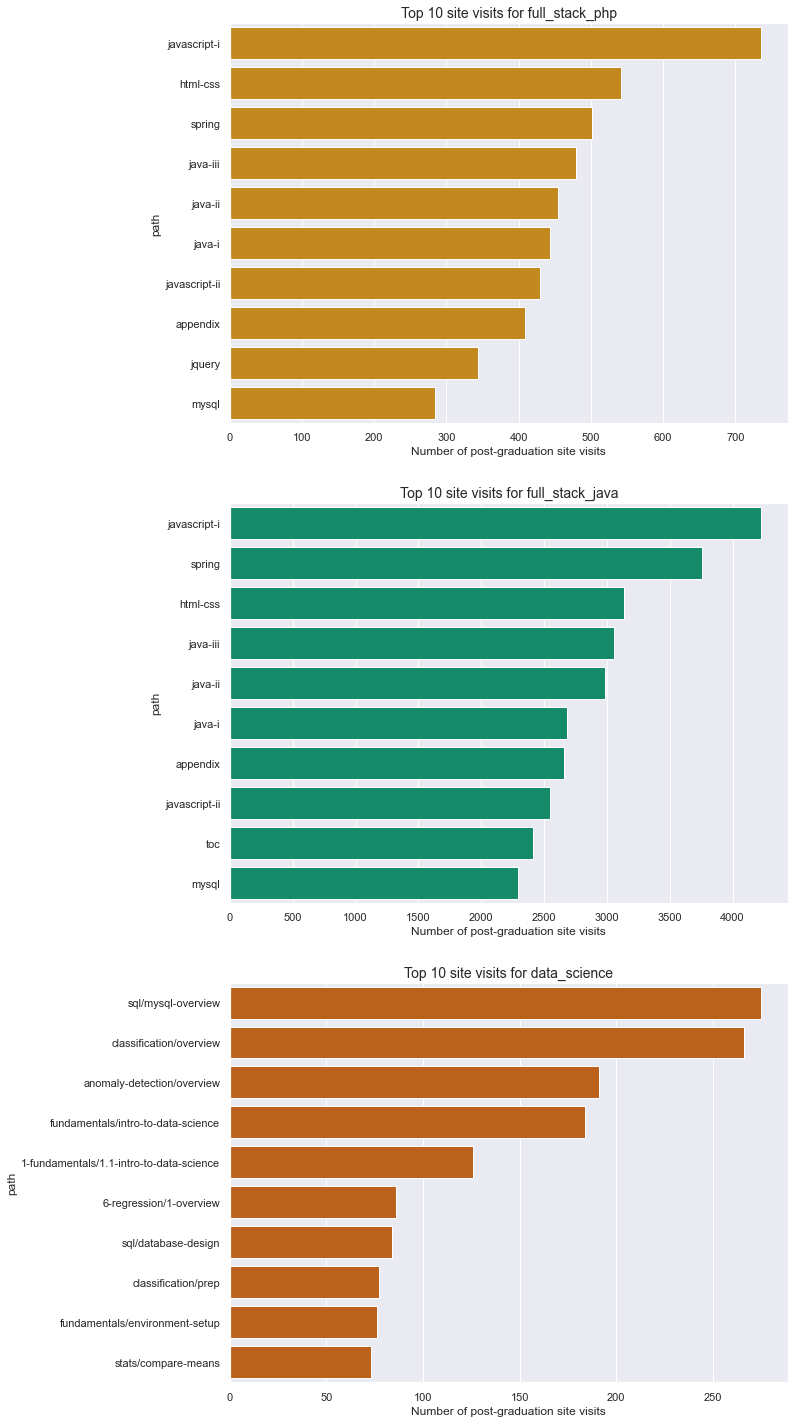

In [7]:
df = wrangle.get_curriculum_data()
question6(df)

### Question 5

##### do additional wrangling

In [8]:
def q5_wrangle(old_df):
    df5 = old_df.copy()
    #drop staff access
    df5 = df5[df5.name != 'Staff']
    #drop unknown cohorts
    df5 = df5[~df5.name.isna()]
    #get first piece of path and store
    df5['path_0'] = df5.path.str.split(pat='/',expand=True).loc[:,0]
    #convert date to datetime format
    df5['date'] = pd.to_datetime(df5['date'],format='%Y-%m-%d')
    return df5
    

In [9]:
def question5(df):
    #do some more wrangling
    df5 = q5_wrangle(df)
    #Get 2020 and later site visits 
    #represents 'clean' data - when students couldn't access each other's curriculum
    df5_rest = df5[df5.date > '2019-12-31']
    
    ############## Section may change if I decide to use the whole path
    #create 'root' paths dataframe - just the first part of the url (after the domain)
    root_paths = pd.DataFrame(df5_rest.path_0.unique()).rename(columns={0:'path_0'}) #261
    #loop over each program
    for cnt,p in enumerate(df5.program_name.unique()):
        #create new column name
        col_name = str(p)
        #make subset of root paths accessed by this program
        prog_paths = df5_rest[df5_rest.program_name == p].path_0
        #create 0/1 column to see if that path was accessed by this program
        root_paths[col_name] = root_paths.path_0.isin(prog_paths).astype(int)

    #Now aggregate and find columns that only one program ever accessed
    root_paths['only_one'] = (1 == root_paths.loc[:,'full_stack_php':'data_science'].sum(axis=1))
    
    #create dataframe of root paths that only one program has access to
    root_paths_rest = root_paths[root_paths.only_one]
    ##############
    
    ##### Now create dataframe of cross_access logs ####
    cross_access = pd.DataFrame()
    #loop over each program
    for cnt, p in enumerate(df5.program_name.unique()):
        #get entries that don't include that program
        df_not_p = df5[df5.program_name != p]
        #now add any inappropriate access times
        #if the path of any other program, is in that exclusive program's url, then add the line
        subset = df_not_p[df_not_p.path_0.isin(root_paths_rest[root_paths_rest[p] == 1].path_0)]
        cross_access = pd.concat([cross_access,subset])

    cross_access.drop_duplicates(inplace=True)
    ##############
    
    ## Plot timeline of 'inappropriate' access
    plt.figure(figsize=(12,6))
    sns.histplot(data=cross_access,x='date',binwidth=12)
    plt.title('Subset of Cross-Curriculum Access Activity',size=14);
    plt.ylabel('Site Visits');
    plt.xlabel('Date');
    
    return None


Returning saved csv files.


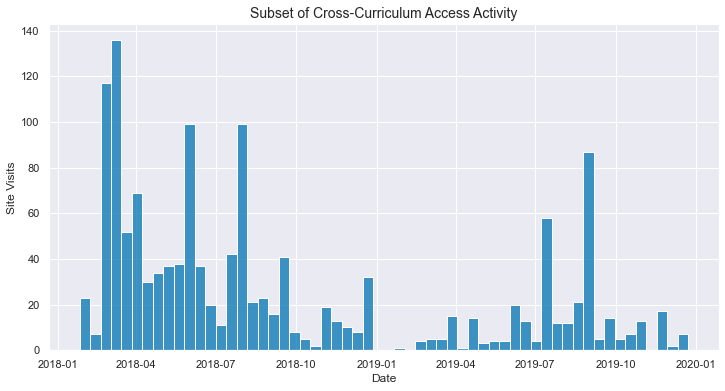

In [10]:
df = wrangle.get_curriculum_data()
question5(df)

In [11]:
def q5_wrangle2(old_df):
    df5 = old_df.copy()
    #drop staff access
    df5 = df5[df5.name != 'Staff']
    #drop unknown cohorts
    df5 = df5[~df5.name.isna()]
    #convert date to datetime format
    df5['date'] = pd.to_datetime(df5['date'],format='%Y-%m-%d')
    df5['end_date'] = pd.to_datetime(df5['end_date'],format='%Y-%m-%d')
    #only look at currently active students
    df5 = df5[df5['date'] <= df5['end_date']]
    return df5

def question5_fullpaths(df):
    #do some more wrangling
    df5 = q5_wrangle2(df)
    #Get 2020 and later site visits 
    #represents 'clean' data - when students couldn't access each other's curriculum
    df5_rest = df5[df5.date > '2019-12-31']
    
    ############## Section may change if I decide to use the whole path
    #create 'root' paths dataframe - just the first part of the url (after the domain)
    all_paths = pd.DataFrame(df5_rest.path.unique()).rename(columns={0:'path'}) #261
    #loop over each program
    for cnt,p in enumerate(df5.program_name.unique()):
        #create new column name
        col_name = str(p)
        #make subset of root paths accessed by this program
        prog_paths = df5_rest[df5_rest.program_name == p].path
        #create 0/1 column to see if that path was accessed by this program
        all_paths[col_name] = all_paths.path.isin(prog_paths).astype(int)

    #Now aggregate and find columns that only one program ever accessed
    all_paths['only_one'] = (1 == all_paths.loc[:,'full_stack_php':'data_science'].sum(axis=1))
    
    #create dataframe of root paths that only one program has access to
    all_paths_rest = all_paths[all_paths.only_one]
    ##############
    
    ##### Now create dataframe of cross_access logs ####
    cross_access = pd.DataFrame()
    #loop over each program
    for cnt, p in enumerate(df5.program_name.unique()):
        #get entries that don't include that program
        df_not_p = df5[df5.program_name != p]
        #now add any inappropriate access times
        #if the path of any other program, is in that exclusive program's url, then add the line
        subset = df_not_p[df_not_p.path.isin(all_paths_rest[all_paths_rest[p] == 1].path)]
        cross_access = pd.concat([cross_access,subset])

    cross_access.drop_duplicates(inplace=True)
    ##############
    
    ## Plot timeline of 'inappropriate' access
    plt.figure(figsize=(12,6))
    sns.histplot(data=cross_access,x='date',binwidth=14)
    plt.title('Subset of Cross-Curriculum Access Activity',size=14);
    plt.ylabel('Site Visits');
    plt.xlabel('Date');
    print(type(cross_access))
    return cross_access

Returning saved csv files.
<class 'pandas.core.frame.DataFrame'>


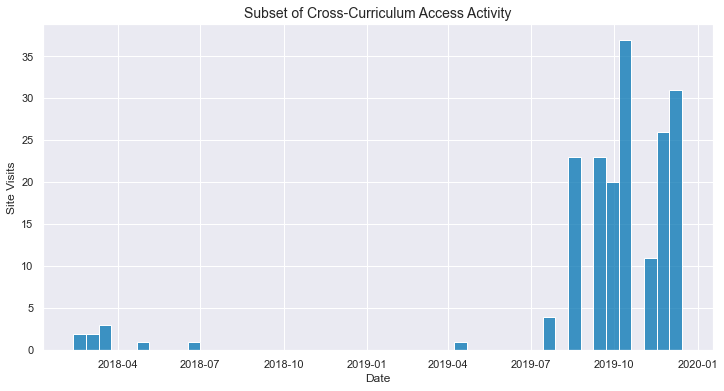

In [12]:
df = wrangle.get_curriculum_data()
cross_access = question5_fullpaths(df)

In [13]:
cross_access.shape

(185, 16)

<AxesSubplot:xlabel='program_name', ylabel='count'>

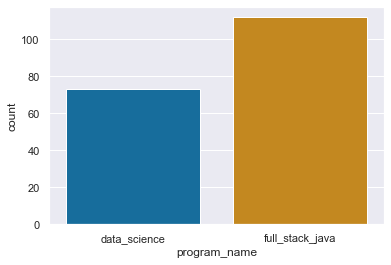

In [14]:
sns.countplot(data=cross_access,x='program_name')

In [15]:
cross_access.path.value_counts().head(20)

html-css                                    16
4-python/1-overview                         16
1-fundamentals/AI-ML-DL-timeline.jpg        12
1-fundamentals/modern-data-scientist.jpg    12
1-fundamentals/1.1-intro-to-data-science    12
javascript-i                                10
appendix/postwork                            8
java-i                                       7
appendix/cli-git-overview                    7
4-python/2-introduction-to-python            6
4-python/3-data-types-and-variables          6
html-css/introduction                        5
spring                                       5
java-iii                                     4
java-ii                                      4
javascript-ii                                4
jquery                                       4
4-python/5-functions                         3
appendix/cli/0-overview                      3
html-css/elements                            3
Name: path, dtype: int64

### Now reframe as in datascience or not.

In [16]:
def q5_wrangle2(old_df):
    df5 = old_df.copy()
    #drop staff access
    df5 = df5[df5.name != 'Staff']
    #drop unknown cohorts
    df5 = df5[~df5.name.isna()]
    #convert date to datetime format
    df5['date'] = pd.to_datetime(df5['date'],format='%Y-%m-%d')
    df5['end_date'] = pd.to_datetime(df5['end_date'],format='%Y-%m-%d')
    #only look at currently active students
    df5 = df5[df5['date'] <= df5['end_date']]
    return df5

def question5_fullpaths2(df):
    #do some more wrangling
    df5 = q5_wrangle2(df)
    #Get 2020 and later site visits 
    #represents 'clean' data - when students couldn't access each other's curriculum
    df5_rest = df5[df5.date > '2019-12-31']
    
    #create list of all paths visited
    all_paths = pd.DataFrame(df5_rest.path.unique()).rename(columns={0:'path'}) #261
    #loop over each program
    for cnt,p in enumerate(df5.program_name.unique()):
        #create new column name
        col_name = str(p)
        #make subset of paths accessed by this program
        prog_paths = df5_rest[df5_rest.program_name == p].path
        #create 0/1 column to see if that path was accessed by this program
        all_paths[col_name] = all_paths.path.isin(prog_paths).astype(int)

    #Now aggregate and find columns that only one program ever accessed
    all_paths['only_one'] = (1 == all_paths.loc[:,'full_stack_java':'data_science'].sum(axis=1))
    
    #create dataframe of data science paths that no one else accessed.
    ds_paths = all_paths[all_paths.only_one & all_paths.data_science]
    not_ds_paths = all_paths[all_paths.only_one & ~all_paths.data_science]
    ##############
    
    ##### Now create dataframe of cross_access logs ####
    cross_access = pd.DataFrame()
    ##
    #drop all ds entries
    cross_access = df5[((df5.program_name == "data_science") & (df5.path.isin(not_ds_paths))) | \
                       ((df5.program_name != "data_science") & (df5.path.isin(ds_paths)))]
    
    ##############
    
    ## Plot timeline of 'inappropriate' access
    plt.figure(figsize=(12,6))
    sns.histplot(data=cross_access,x='date',binwidth=14)
    plt.title('Subset of Cross-Curriculum Access Activity',size=14);
    plt.ylabel('Site Visits');
    plt.xlabel('Date');
    print(type(cross_access))
    return cross_access, all_paths

Returning saved csv files.
<class 'pandas.core.frame.DataFrame'>


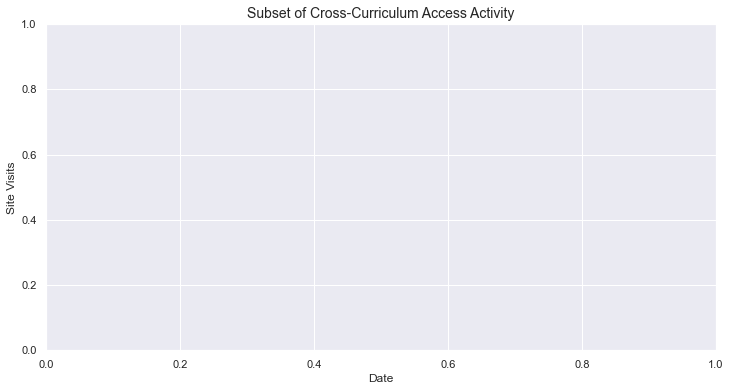

In [17]:
df = wrangle.get_curriculum_data()
cross_access, all_paths = question5_fullpaths2(df)

In [18]:
all_paths

,path,full_stack_java,data_science,only_one
0,java-i,1,0,True
1,java-ii,1,0,True
2,java-i/syntax-types-and-variables,1,0,True
3,java-i/control-statements-and-loops,1,0,True
4,html-css,1,0,True
...,...,...,...,...
991,spring/views,1,0,True
992,setup,1,0,True
993,appendix/professional-development/interview-gu...,0,1,True
994,python/pandas-lesson,0,1,True


In [19]:
cross_access

,date,time,path,user_id,cohort_id,ip,id,name,slack,start_date,end_date,created_at,updated_at,deleted_at,program_id,program_name


### Question 8!

In [21]:
def activity_wrangle(old_df):
    df8 = old_df.copy()
    #drop staff
    df8 = df8[df8.name != 'Staff']
    #Convert these columns to datetimes
    df8['date'] = pd.to_datetime(df8['date'],format='%Y-%m-%d')
    df8['start_date'] = pd.to_datetime(df8['start_date'],format='%Y-%m-%d')
    df8['end_date'] = pd.to_datetime(df8['end_date'],format='%Y-%m-%d')
    #subset into just active dates
    df8 = df8[df8['date'] <= df8.end_date]

    #create days after course start
    df8['days_in'] = (df8['date'] - df8['start_date']).astype('timedelta64[D]')
    df8['curriculum_week'] = df8['days_in'] // 7
    
    #create program subsets
    df8_wd = df8[df8.program_name == 'full_stack_java']
    df8_ds = df8[df8.program_name == 'data_science']
    
    return df8_wd, df8_ds   

In [40]:
def activity_calc_and_plot(df):
    #grab program name
    program_name = df.program_name.unique()[0]
    ####CALCULATE
    #group by curriculum and week
    ds_grp = df.groupby(['curriculum_week','name'])
    #get count of visits per week per cohort
    df8_3 = pd.DataFrame(ds_grp.time.count())
    #unstack so columns are weeks and cohorts are rows
    df8_3 = df8_3.unstack(level=0)
    #Loop over each cohort
    for coh in df8_3.index:
        #get num students in cohort
        num_stud = df[df.name == coh].user_id.nunique()
        #convert df to weekly visits per student
        df8_3.loc[coh,:] = df8_3.loc[coh,:] / num_stud
    #drop unneeded multindex
    df8_3.columns = df8_3.columns.droplevel(0)
    
    ####PLOT
    plt.figure(figsize=(12,6))
    colors = sns.color_palette('colorblind').as_hex()
    for cnt,coh in enumerate(df8_3.index):
        #only 10 colors, plus at that point its too busy
        if cnt == 10: break
        sns.lineplot(x=df8_3.columns, y=df8_3.loc[coh,:],color=colors[cnt],alpha=.8,label=coh)

    plt.title(f'Weekly Activity per Student - {program_name}',size=14)
    plt.legend()
    plt.show()
    
    return None
    

In [41]:
def question8_activity(df):
    #wrangle and get program dataframes
    wd, ds = activity_wrangle(df)
    #calc and plot for each program
    activity_calc_and_plot(wd)
    activity_calc_and_plot(ds)
    return None

Returning saved csv files.


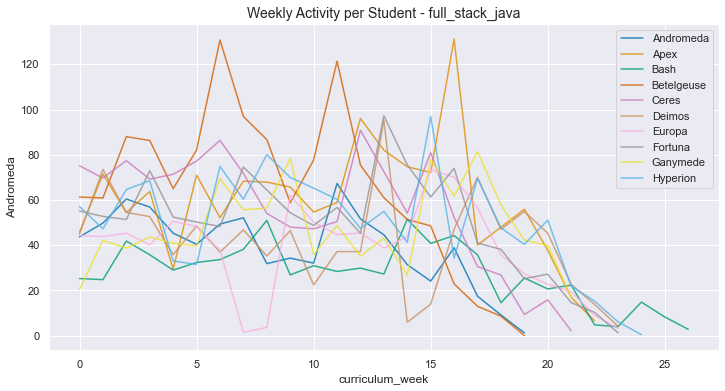

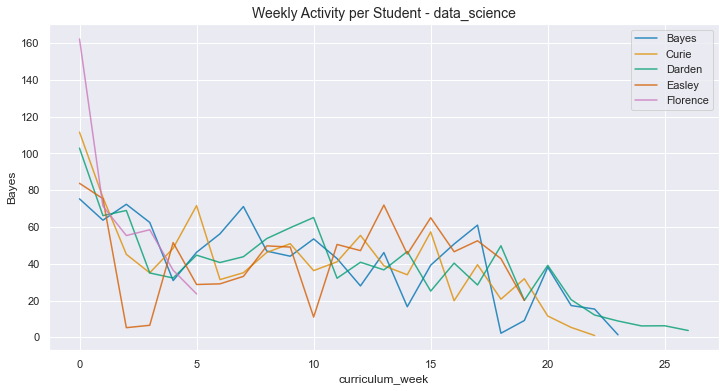

In [42]:
df = wrangle.get_curriculum_data()
question8_activity(df)